# Twitter Sentiment Analysis — Beginners Dataset (Kaggle) QuickStart

This notebook loads the **Twitter Sentiment Analysis for Beginners** dataset from Kaggle (auto-detected),
or falls back to a local CSV at `data/sentiment.csv` with columns **text,label**.

Pipeline:
1. Auto-detect & load data
2. Basic text cleaning (URLs, @users, hashtags, punctuation, whitespace)
3. Train/validation split
4. TF‑IDF (unigrams + bigrams)
5. Models: Naive Bayes & Logistic Regression
6. Metrics + Confusion Matrix (saved to `plots/confusion_matrix.png`)
7. Save best model & vectorizer

In [23]:
# === Auto-detect + Load Sentiment140 + (Optional) Sample + Clean ===
import os, re
import pandas as pd

# 1) 自動偵測 Kaggle input 資料夾（兩個都支援），或本機同層檔案
candidates = [
    "/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv",
    "/kaggle/input/training160m/training.1600000.processed.noemoticon.csv",
    "training.1600000.processed.noemoticon.csv",  # 本機/Colab 同層
]
csv_path = next((p for p in candidates if os.path.exists(p)), None)
if csv_path is None:
    # 小幫手：列出 /kaggle/input 讓你對照
    print("Mounted under /kaggle/input:", os.listdir("/kaggle/input") if os.path.isdir("/kaggle/input") else "N/A")
    raise FileNotFoundError("找不到 Sentiment140 CSV，請在右側 Add data 或把檔案放到與 notebook 同層。")

print("Using file:", csv_path)

# 2) 讀檔（latin-1、無欄名）
df = pd.read_csv(
    csv_path,
    encoding="latin-1",
    header=None,
    names=["target","ids","date","flag","user","text"]
)[["text","target"]]

# 3) label 轉換
df["label"] = df["target"].map({0: "negative", 4: "positive"})
df = df[["text","label"]].dropna().reset_index(drop=True)
print("原始資料：", df.shape, "\n", df["label"].value_counts())

# 4) (可選) 抽樣加速：先跑 50k 觀察流程，穩了再改為 None 全量
sample_size = 50000   # ← 想全量就改成 None
if sample_size is not None and sample_size < len(df):
    df = df.sample(sample_size, random_state=42).reset_index(drop=True)
print("使用資料：", df.shape, "\n", df["label"].value_counts())

# 5) 基礎清理（網址/@/hashtag/符號/多空白）
def clean_text(s):
    s = s.lower()
    s = re.sub(r"http\\S+|www\\S+", " ", s)     # URLs
    s = re.sub(r"@[A-Za-z0-9_]+", " ", s)      # @users
    s = re.sub(r"#\\S+", " ", s)               # hashtags
    s = re.sub(r"[^a-z0-9\\s]", " ", s)        # 只留英數與空白
    s = re.sub(r"\\s+", " ", s).strip()
    return s

df["text"] = df["text"].astype(str).apply(clean_text)
df = df[df["text"].str.len() > 0].reset_index(drop=True)
print("清理後：", df.shape)

# 6)（可選）存一份乾淨資料，讓通用 sentiment 專案也能直接用
os.makedirs("data", exist_ok=True)
df.to_csv("data/sentiment.csv", index=False)
print("已另存清理後資料 -> data/sentiment.csv")

# 檢視前 3 筆
df.head(3)


Using file: /kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv
原始資料： (1600000, 2) 
 label
negative    800000
positive    800000
Name: count, dtype: int64
使用資料： (50000, 2) 
 label
positive    25014
negative    24986
Name: count, dtype: int64
清理後： (49888, 2)
已另存清理後資料 -> data/sentiment.csv


,text,label
0,ahhh i hope your ok,negative
1,cool i have no tweet apps for my razr 2,negative
2,i know just family drama its lame hey next t...,negative


In [24]:
# 為了先測試流程，可以只抽 50,000 筆
sample_size = 50000   # None 表示用全部 1.6M 筆
if sample_size is not None and sample_size < len(df):
    df = df.sample(sample_size, random_state=42).reset_index(drop=True)

print("使用資料筆數:", df.shape)
print(df["label"].value_counts())


使用資料筆數: (49888, 2)
label
positive    24949
negative    24939
Name: count, dtype: int64


In [25]:
def clean_text(s):
    s = s.lower()
    s = re.sub(r"http\\S+|www\\S+", " ", s)    # 移除網址
    s = re.sub(r"@[A-Za-z0-9_]+", " ", s)     # 移除 @user
    s = re.sub(r"#\\S+", " ", s)              # 移除 hashtags
    s = re.sub(r"[^a-z0-9\\s]", " ", s)       # 移除符號，只留字母/數字
    s = re.sub(r"\\s+", " ", s).strip()       # 移除多餘空白
    return s

df["text"] = df["text"].astype(str).apply(clean_text)
df = df[df["text"].str.len() > 0].reset_index(drop=True)

print("清理後資料:", df.shape)
df.head()


清理後資料: (49888, 2)


,text,label
0,ahhh i hope your ok,negative
1,cool i have no tweet apps for my razr 2,negative
2,i know just family drama its lame hey next t...,negative
3,school email won t open and i have geography ...,negative
4,upper airways problem,negative


In [26]:
X = df["text"]
y = df["label"]

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

vectorizer = TfidfVectorizer(
    stop_words="english",
    max_features=200000,   # 大一點 feature 空間
    ngram_range=(1,2),     # unigram + bigram
    min_df=2
)

X_train_vec = vectorizer.fit_transform(X_train)
X_valid_vec = vectorizer.transform(X_valid)

X_train_vec.shape, X_valid_vec.shape


((39910, 30000), (9978, 30000))

In [27]:
models = {
    "NaiveBayes": MultinomialNB(),
    "LogReg": LogisticRegression(max_iter=2000, n_jobs=None)
}

metrics = {}
for name, m in models.items():
    m.fit(X_train_vec, y_train)
    preds = m.predict(X_valid_vec)
    acc = accuracy_score(y_valid, preds)
    metrics[name] = acc
    print(f"[{name}] Accuracy = {acc:.4f}")
    print(classification_report(y_valid, preds, digits=4, zero_division=0))

best_name = max(metrics, key=metrics.get)
best_model = models[best_name]
print("最佳模型:", best_name, "Accuracy:", metrics[best_name])


[NaiveBayes] Accuracy = 0.7417
              precision    recall  f1-score   support

    negative     0.7396    0.7460    0.7428      4988
    positive     0.7439    0.7375    0.7407      4990

    accuracy                         0.7417      9978
   macro avg     0.7417    0.7417    0.7417      9978
weighted avg     0.7418    0.7417    0.7417      9978

[LogReg] Accuracy = 0.7497
              precision    recall  f1-score   support

    negative     0.7580    0.7336    0.7456      4988
    positive     0.7420    0.7659    0.7538      4990

    accuracy                         0.7497      9978
   macro avg     0.7500    0.7497    0.7497      9978
weighted avg     0.7500    0.7497    0.7497      9978

最佳模型: LogReg Accuracy: 0.7497494487873322


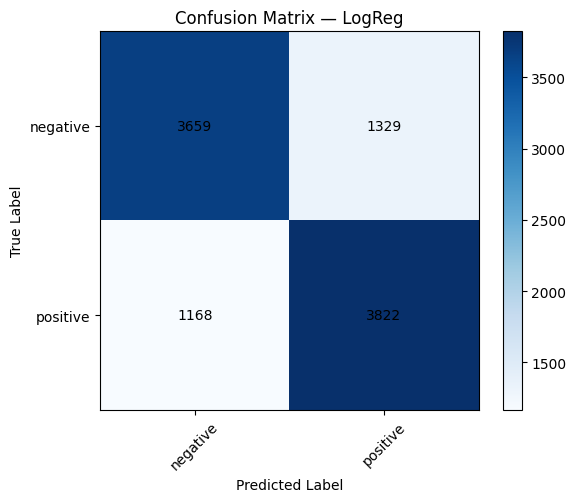

In [28]:
labels = sorted(y_valid.unique())
preds = best_model.predict(X_valid_vec)
cm = confusion_matrix(y_valid, preds, labels=labels)

plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest', cmap="Blues")
plt.title(f'Confusion Matrix — {best_name}')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig("plots/confusion_matrix.png", dpi=150, bbox_inches='tight')
plt.show()


In [29]:
import pickle

with open("sentiment140_best_model.pkl","wb") as f:
    pickle.dump(best_model, f)

with open("sentiment140_tfidf.pkl","wb") as f:
    pickle.dump(vectorizer, f)

print("已存 sentiment140_best_model.pkl 與 sentiment140_tfidf.pkl")


已存 sentiment140_best_model.pkl 與 sentiment140_tfidf.pkl
